In [1]:
# this code gets either the images or the patches to trian the pre-trained model

# use this cell to import all necessary libraries

import os
# to run on GPU, comment the following tow lines 
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"] = ""
import pandas
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing import image
import cv2
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.applications import VGG16
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import preprocess_input
import pylab
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras.models import Model
from util import read_data_random_view, read_patch_test, read_patch_rvs_test, gray2RGB
from util_pre import read_data
from keras.models import load_model
from sklearn.metrics import confusion_matrix
import random

Using TensorFlow backend.


In [2]:
# use this cell to get all of the input parameters and paths to train and tune

# if you want to train on images, choose RC = 1
# if you want to train on patches, choose RC = 2

RC = 1 # running code

# input shapes for the pretrained models(input_shape is the image shape or the patch shape)

input_shape=(224, 224, 3)

# input parameters and paths for training

csvPath = '/home/mohammadali/Downloads/Run/Train.csv'
imagePath = '/home/mohammadali/Downloads/Run/Train-Seg-Man'
patchPath = '/home/mohammadali/Downloads/Run/Train-Patch'
inputSize = (224, 224)
patchSize = (64, 64)
split_ratio = 0.15
batch_size = 32
learning_rate = 5e-6
epoch_size = 50
nodes = 1024 # number of nodes for the fc layer
drop_out = 0.75 # the layer after the fc layer

# input parameters and paths for testing

test_dir = '/home/mohammadali/Downloads/Run/Test-Seg-Man'
test_dir_patch = '/home/mohammadali/Downloads/Run/Test-Patch'
csvTest = '/home/mohammadali/Downloads/Run/Test.csv'
IMG_SIZE = 224 
Patch_SIZE = 64

Labels loaded: 50 positive,45 negatve.
Split dataset according to Patients. Training : 27 patients and 480 images; Validation : 5 patients and 90 images

using images

train_images: (480, 224, 224, 3)
train_labels: (480,)
validation_images: (90, 224, 224, 3)
validation_label: (90,)

getting the model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
15/15 [==============================] - 5s 362ms/step - loss: 0.8895 - acc: 0.5104 - val_loss: 0.7593 - val_acc: 0.3444
Epoch 2/50
15/15 [==============================] - 3s 167ms/step - loss: 0.8358 - acc: 0.5479 - val_loss: 0.6200 - val_acc: 0.7667
Epoch 3/50
15/15 [==============================] - 4s 234ms/step - loss: 0.7759 - acc: 0.5833 - val_loss: 0.6930 - val_acc: 0.4778
Epoch 4/50
15/15 [==============================] - 4s 235ms/step 

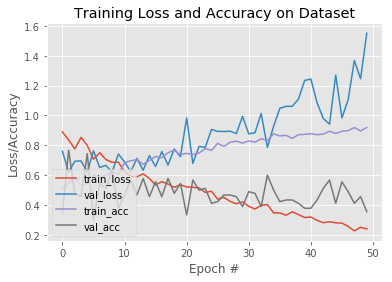

In [3]:
# use this cell to train the model (all of the inputs have been given in the second cell)

# preparing the data to train

random.seed(7)

if RC == 1:
    train_img, train_label, val_img, val_label = read_data(csvPath,
            imagePath, inputSize, split_ratio, split_by_id = True, normalize = True, crop_image = True)
    train_img = np.stack( (train_img[:,:,:,0],)*3, axis=-1 )
    val_img = np.stack( (val_img[:,:,:,0],)*3, axis=-1 )
    print("")
    print("using images")
    print("")
    print("train_images:", train_img.shape)
    print("train_labels:", train_label.shape)
    print("validation_images:", val_img.shape)
    print("validation_label:", val_label.shape)
    print("")
elif  RC == 2:
    train_img, train_label, val_img, val_label = \
    read_data_random_view(csvPath, imagePath, patchPath, inputSize, patchSize, split_ratio, kfold=1, outchannels=3)
    print("")
    print("using patches")
    print("")
    print('train_patches:', train_img.shape)
    print('train_labels:', train_label.shape)
    print('validation_patches:', val_img.shape) 
    print('validation_labels:', val_label.shape)
    print("")

print("getting the model")
print("")
# using the pretrained model for training

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
#conv_base = ResNet50(weights = 'imagenet', include_top = False, input_shape = input_shape)
#conv_base.summary()

for layer in conv_base.layers[:-4]:
    layer.trainable = False

# Check the trainable status of the individual layers

#for layer in conv_base.layers:
#    print(layer, layer.trainable)

# making the FC layers of the model

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(nodes, activation='relu'))
model.add(layers.Dropout(drop_out))
model.add(layers.Dense(1, activation='sigmoid'))
#model.summary()

# compiling the model

model.compile(loss='binary_crossentropy', optimizer=optimizers.adam(lr=learning_rate), metrics=['acc'])

# data augmentation

train_datagen = ImageDataGenerator(rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

#val_datagen = ImageDataGenerator(rescale=1./255)

# training the model

H = model.fit_generator(
        train_datagen.flow(train_img, train_label, batch_size = batch_size),
        steps_per_epoch=len(train_img) // batch_size,
        epochs = epoch_size,
        validation_data = (val_img,val_label),
        validation_steps = len(val_img) // batch_size)

# plotting the training loss and accuracy

print("")
plt.style.use("ggplot")
plt.figure()
N = epoch_size
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

# saving the model

model.save_weights('model_weights_lung_pro.h5')
model.save('model_lung_pro.h5')

shape of X_test: (21, 224, 224)
shape of X_testing1: (21, 224, 224, 3)
shape of X_test_patch: (21, 64, 64)
shape of X_testing2: (21, 64, 64, 3)
shape of y_test: (21,)

testing images
21/21 [==============================] - 1s 30ms/step

Predicted labels: [0 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 0 1]

True labels: [0 0 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0]

[ True  True False  True  True  True False False False False  True  True
  True False  True  True False False False  True False]


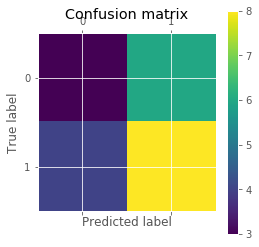

In [4]:
# use this cell to test the model (all of the inputs have been given in the second cell)

# loading the model

if  RC == 1:
    model = load_model('model_lung_pro.h5')
elif  RC == 2:
    model = load_model('model_lung_pro.h5')
#model.summary()

# getting the images for testing

file_list2 = os.listdir(test_dir)
test_imgs = [test_dir + "/" + "{}".format(i) for i in file_list2]
#print("No. of test images = ", len(test_imgs))
    
X_test = []
for image in test_imgs:
    X_test.append(cv2.resize(cv2.imread(image, cv2.IMREAD_GRAYSCALE), (IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_CUBIC))
X_test = np.array(X_test)
X_test = (X_test-np.min(X_test))/(np.max(X_test)-np.min(X_test))
#X_test = X_test/255.0
print("shape of X_test:", X_test.shape)

X_testing1 = []
for m in range (len(X_test)):
    X_testt = X_test[m]
    X_testing1.append(gray2RGB(X_testt))
X_testing1 = np.array(X_testing1)
print("shape of X_testing1:", X_testing1.shape)

# getting the patches for testing

file_list3 = os.listdir(test_dir_patch)
test_imgs_patch = [test_dir_patch + "/" + "{}".format(i) for i in file_list3]
#print("No. of test images = ", len(test_imgs))
X_test_patch = []
for image in test_imgs_patch:
    X_test_patch.append(cv2.resize(cv2.imread(image, cv2.IMREAD_GRAYSCALE), (Patch_SIZE, Patch_SIZE), interpolation=cv2.INTER_CUBIC))

X_test_patch = np.array(X_test_patch)
print("shape of X_test_patch:", X_test_patch.shape)

X_test_final = []
for h in range (len(X_test_patch)):
    X_test_final.append(read_patch_test(X_test[h], X_test_patch[h], patch_size = (Patch_SIZE, Patch_SIZE)))
X_test_final = np.array(X_test_final)

X_testing2 = []
for m in range (len(X_test_final)):
    X_testt = X_test_final[m]
    X_testing2.append(gray2RGB(X_testt))
X_testing2 = np.array(X_testing2)
print("shape of X_testing2:", X_testing2.shape)

# getting the true labels for testing
    
df = pandas.read_csv(csvTest)
#print('shape of the dataframe:', df.shape)
#print(df.head(2))
na = df.loc[:,'File']
la = df.loc[:,'Progression']
na = np.array(na)
la = np.array(la)
I = np.argsort(na)
na = na[I]
la = la[I]
y_test = la
#sns.set(rc={'figure.figsize':(5,4)})
#sns.countplot (y_test)
#plt.title("Labels")
print ("shape of y_test:", y_test.shape)
print("")

# model prediction

if  RC == 1:
    print("testing images")
    preds_test = model.predict(X_testing1, verbose=1)
elif  RC == 2:
    print("testing patches")
    preds_test = model.predict(X_testing2, verbose=1)
    
preds_test_t = (preds_test > 0.5).astype(np.uint8)
predictions_test = preds_test_t [:, 0]
print("")
print("Predicted labels:", predictions_test)
print("")
print("True labels:", y_test)
print("")
com = np.isclose(predictions_test, y_test.T)
print (com)
#true_prediction_number = 1 * (com == 'True')
#print(true_prediction_number)
cm = confusion_matrix(y_test, predictions_test)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()